# description 5/01/19 clinically guided aggregation modeling

sklearn modeling using local methods of the median imputed training data using origional min/max clinically guided aggregation. note the preprocessing of data from 07.20-worst_case_model was performed in R (09.newagg2_preprocessing_med_impute.rmd). this eventually will be converted over to python, but for now works in r. 

preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm


#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'


#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)


memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})


%load_ext autotime

# functions related to gower distance, preprocessing, finding train samples, etc...

In [2]:
def _return_float_dtype(X, Y):
    ##used in grower distance, converts values to floats for formatting.
    """
    1. If dtype of X and Y is float32, then dtype float32 is returned.
    2. Else dtype float is returned.
    """
    if not issparse(X) and not isinstance(X, np.ndarray):
        X = np.asarray(X)

    if Y is None:
        Y_dtype = X.dtype
    elif not issparse(Y) and not isinstance(Y, np.ndarray):
        Y = np.asarray(Y)
        Y_dtype = Y.dtype
    else:
        Y_dtype = Y.dtype

    if X.dtype == Y_dtype == np.float32:
        dtype = np.float32
    elif X.dtype == np.object and not issparse(X):
        dtype = np.float
        for col in range(X.shape[1]):
            if not np.issubdtype(type(X[0, col]), np.number):
                dtype = np.object
                break
    else:
        dtype = np.float
    return X, Y, dtype


time: 31.4 ms


In [3]:
def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    ##used in grower distance, checks x and y dimensions against each otehr.
    X, Y, dtype_float = _return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float
    
    ##Input validation on an array, list, sparse matrix or similar.
    ##By default, the input is checked to be a non-empty 2D array containing only finite values.
    
    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y

time: 23.8 ms


In [4]:
def gower_distances(X, Y=None, w=None, categorical_features=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    w:  array-like, shape (n_features)
    According the Gower formula, w is an attribute weight.

    categorical_features: array-like, shape (n_features)
    Indicates with True/False wheter a column is a categorical attribute.
    This is useful when categorical atributes are represented as integer
    values.

    Returns
    -------
    similarities : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    """

    X, Y = check_pairwise_arrays(X, Y, dtype=(np.object, None)[issparse(X) or
                                                               issparse(Y)])
    rows, cols = X.shape

    if categorical_features is None:
        categorical_features = []
        for col in range(cols):
            if np.issubdtype(type(X[0, col]), np.number):
                categorical_features.append(False)
            else:
                categorical_features.append(True)
    # Calculates the normalized ranges and max values of numeric values
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if not categorical_features[col]:
            max = None
            min = None
            if issparse(X):
                col_array = X.getcol(col)
                max = col_array.max() + 0.0
                min = col_array.min() + 0.0
            else:
                col_array = X[:, col].astype(np.double)
                max = np.nanmax(col_array)
                min = np.nanmin(col_array)

            if np.isnan(max):
                max = 0.0
            if np.isnan(min):
                min = 0.0
            max_of_numeric[col] = max
            ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)

    for i in range(0, rows):
        j_start = i

        # for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = X[i, col]
                value_xj = Y[j, col]

                if not categorical_features[col]:
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0:
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij = 0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij

            if sum_wij != 0:
                dm[i, j] = (sum_sij / sum_wij)
                if j < rows and i < yrows:
                    dm[j, i] = dm[i, j]
    return dm


time: 217 ms


In [5]:
# ##testing grower distance
# x_train1=x_train.iloc[:100,1:20]
# x_train2=x_train.iloc[101:201,1:20]
# print(len(x_train1), #2715
# len(x_train2)) #2715

time: 922 µs


In [6]:
# gower_distances(X=x_train1, Y=x_train2, w=None, categorical_features=None) #works

time: 644 µs


In [7]:
def select_train_samples(sample_id, all_xy, m, time_interval):# m is number of similar cases or controls
    num_control = m   # the ratio of case and control is 1:2, 1:3,1:4
    
    ####not sure what this is doing.
    if time_interval == 24:
        top_con_variables = [False]*128
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
    else:
        top_con_variables = [False]*129  #there is another item in other hours
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
        
    ##all_xy = all_xy.fillna(np.nan) # fill empty with nan

    x_candidate_label = all_xy.loc[sample_id] # get the object sample
    x_candidate = x_candidate_label.drop('label')
    x_candidate_tem = x_candidate.as_matrix()
    testing_sample = x_candidate_tem.reshape(1, -1)  # covert into ....

    all_x_candidate_tem = all_xy.drop([sample_id], axis=0, inplace=False) # delete the object sample from whole set

# select similar cases
    all_cases = all_x_candidate_tem[all_x_candidate_tem.label == 1]
    all_cases_candidate = all_cases.drop(['label'], axis=1, inplace=False)
    gower_candidate_case = all_cases_candidate.values[:, :] # convert into ndarray

    Gower_Distance_1 = gower_distances(gower_candidate_case, testing_sample, categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_2 = list(Gower_Distance_1)
    Gower_Distance_3 = pd.Series(Gower_Distance_2, index = all_cases_candidate.index)
    Gower_Distance_4 = Gower_Distance_3.sort_values(ascending=False)

    Id_selected_cases = Gower_Distance_4.index[:m].tolist() # the id set of the top m similar samples

# select similar controls
    all_controls = all_x_candidate_tem[all_x_candidate_tem.label == 0]
    all_controls_candidate = all_controls.drop(['label'], axis=1, inplace=False)
    gower_candidate_control = all_controls_candidate.values[:, :] # convert into ndarray

    Gower_Distance_11 = gower_distances(gower_candidate_control, testing_sample,categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_22 = list(Gower_Distance_11)
    Gower_Distance_33 = pd.Series(Gower_Distance_22, index = all_controls_candidate.index)
    Gower_Distance_44 = Gower_Distance_33.sort_values(ascending=False)

    Id_selected_controls = Gower_Distance_44.index[:num_control].tolist() # the id set of the top m similar samples

    train_set_id = Id_selected_controls+Id_selected_cases

    train_set_id = np.array(train_set_id)
    return train_set_id

time: 96.2 ms


individualization_predictor.py:

In [8]:
#folder = '/Users/xuzhenxing/Documents/mimic_AKI_data/real_time_prediction/features/all/dropped/xy'
# folder = './xy'

def preprocessing(folder, time_interval, isnormalized=True):
    """Data preprocessing, Preprocessing  missing data with mean imputation; Normalize continous feature with MinMaxScaler;
    Normalize categorical feature with OneHotEncoder.

    Args:
        folder: dir path of source data;
        time_interval: interval of time, can be 24,48,72,96,120,144.
    Returns:
        x: features
        y: lables

    """

    all_xy = pd.read_csv(os.path.join(folder, 'all_{}hours_test_individualization_1thousand.csv'.format(time_interval)), index_col=0)
    # print (all_xy.shape)
    # print (all_xy.columns)

    medi = ['diuretics', 'nsaid', 'radio', 'angiotensin']
    pat = ['gender', 'age', 'ethnicity']
    # Total 9 comorbidity
    comm = ['congestive_heart_failure', 'peripheral_vascular', 'hypertension',
            'diabetes', 'liver_disease', 'mi', 'cad', 'cirrhosis', 'jaundice']

    # Total 8 chartevents
    chart = ['DiasBP_min', 'DiasBP_max', 'DiasBP_first', 'DiasBP_last', 'DiasBP_slope', 'DiasBP_avg',
             'Glucose_min', 'Glucose_max', 'Glucose_first', 'Glucose_last', 'Glucose_slope', 'Glucose_avg',
             'HeartRate_min', 'HeartRate_max', 'HeartRate_first', 'HeartRate_last', 'HeartRate_slope', 'HeartRate_avg',
             'MeanBP_min', 'MeanBP_max', 'MeanBP_first', 'MeanBP_last', 'MeanBP_slope', 'MeanBP_avg',
             'RespRate_min', 'RespRate_max', 'RespRate_first', 'RespRate_last', 'RespRate_slope', 'RespRate_avg',
             'SpO2_min', 'SpO2_max', 'SpO2_first', 'SpO2_last', 'SpO2_slope', 'SpO2_avg',
             'SysBP_min', 'SysBP_max', 'SysBP_first', 'SysBP_last', 'SysBP_slope', 'SysBP_avg',
             'Temp_min', 'Temp_max', 'Temp_first', 'Temp_last', 'Temp_slope', 'Temp_avg']

    # Total 12 labvents
    lab = ['BICARBONATE_first', 'BICARBONATE_last', 'BICARBONATE_min', 'BICARBONATE_max', 'BICARBONATE_avg',
           'BICARBONATE_slope', 'BICARBONATE_count',
           'BUN_first', 'BUN_last', 'BUN_min', 'BUN_max', 'BUN_avg', 'BUN_slope', 'BUN_count',
           'CHLORIDE_first', 'CHLORIDE_last', 'CHLORIDE_min', 'CHLORIDE_max', 'CHLORIDE_avg', 'CHLORIDE_slope',
           'CHLORIDE_count',
           'CREATININE_first', 'CREATININE_last', 'CREATININE_min', 'CREATININE_max', 'CREATININE_avg',
           'CREATININE_slope', 'CREATININE_count',
           'HEMOGLOBIN_first', 'HEMOGLOBIN_last', 'HEMOGLOBIN_min', 'HEMOGLOBIN_max', 'HEMOGLOBIN_avg',
           'HEMOGLOBIN_slope', 'HEMOGLOBIN_count',
           'INR_first', 'INR_last', 'INR_min', 'INR_max', 'INR_avg', 'INR_count',
           'PLATELET_first', 'PLATELET_last', 'PLATELET_min', 'PLATELET_max', 'PLATELET_avg', 'PLATELET_slope',
           'PLATELET_count',
           'POTASSIUM_first', 'POTASSIUM_last', 'POTASSIUM_min', 'POTASSIUM_max', 'POTASSIUM_avg', 'POTASSIUM_slope',
           'POTASSIUM_count',
           'PT_first', 'PT_last', 'PT_min', 'PT_max', 'PT_avg', 'PT_count',
           'PTT_first', 'PTT_last', 'PTT_min', 'PTT_max', 'PTT_avg', 'PTT_count',
           'WBC_first', 'WBC_last', 'WBC_min', 'WBC_max', 'WBC_avg', 'WBC_slope', 'WBC_count',
           'CALCIUM_first', 'CALCIUM_last', 'CALCIUM_min', 'CALCIUM_max', 'CALCIUM_avg', 'CALCIUM_count'
           ]

    if time_interval != 24:  # The 24h data lack of the feature 'CALCIUM_slope'
        lab.append('CALCIUM_slope')
    subset = medi + pat + comm + ['avg_urine'] + ['egfr_min'] + ['label'] # note that ['avg_urine'] + ['egfr_min'] is important, ignoring if they are empty.

    all_xy = all_xy.dropna(subset=subset)

    # print ('after dropping nan in the catergorical variables, the shape is {}'.format(all_xy.shape))

    all_conti_x = all_xy[chart + lab + ['avg_urine'] + ['egfr_min'] + ['age']]
    # print (all_conti_x.shape)
    # print (all_conti_x)
    all_categ_x = all_xy[['gender'] + ['ethnicity'] + medi + comm]
    # print (all_categ_x.shape)
    # print (all_categ_x)

    # Using mean imputer after drop the nan data in medication, patient demographic data, avg_ureine, egfr_min and label
    imp = Imputer(strategy='mean', axis=0)
    all_conti_x_fitted = imp.fit_transform(all_conti_x)

    def normalize(all_conti_x_fitted, all_categ_x):
        # using the MinMaxScaler to normalization the all_x
        min_max_scaler = MinMaxScaler()
        all_conti_x_fitted = min_max_scaler.fit_transform(all_conti_x_fitted)
        # print (all_conti_x_fitted.shape, all_conti_x_fitted)
        # all_conti_x = DataFrame(all_conti_x_fitted, columns=all_conti_x.columns)
        # print (all_conti_x.shape)

        onehot_enc = OneHotEncoder(sparse=False)  # dense format
        all_categ_x_fitted = onehot_enc.fit_transform(all_categ_x)
        # print (all_categ_x_fitted.shape, all_categ_x_fitted)
        return all_conti_x_fitted, all_categ_x_fitted

    if isnormalized:
        all_conti_x_fitted, all_categ_x_fitted = normalize(all_conti_x_fitted, all_categ_x)

    x = np.hstack((all_conti_x_fitted, all_categ_x_fitted))
    # y = all_xy['label']
    # x = np.array(x)
    # y = np.array(y)
    # print (x.shape, y.shape)
    # return x, y
    y = all_xy['label']
    z_icustay_id = y.index
    x = np.array(x)
    y = np.array(y)
    z_icustay_id = np.array(z_icustay_id)

    print (x.shape, y.shape)
    return x, y, z_icustay_id, all_xy


time: 216 ms


In [9]:
def perf_model(pipe, param_grid, name, X_train, X_test,
               y_train, y_test, scoring, verbose=0):
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, verbose=verbose)
    gs.fit(X_train, y_train)

    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)

    acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

    fpr, tpr, _ = roc_curve(y_train, gs.predict_proba(X_train)[:, 1])
    auc_train = auc(fpr, tpr)

    fpr, tpr, _ = roc_curve(y_test, gs.predict_proba(X_test)[:, 1])
    auc_test = auc(fpr, tpr)

    confmat_train = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    confmat_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

    print (' best parameter: ', gs.best_params_)
    print (' training acc:%.2f auc:%.2f ' % (acc_train, auc_train))
    print (' testing acc:%.2f auc:%.2f ' % (acc_test, auc_test))

    print (' train confusion matrix:\n', confmat_train)
    print (' testing confusion matrix:\n', confmat_test)
    print (' classification report:\n', classification_report(y_test, y_test_pred))

    train_report = np.array(precision_recall_fscore_support(y_train, y_train_pred))
    train_class1_report = train_report[:, 1]
    train_metrics = list(train_class1_report[:-1])
    train_metrics.extend([acc_train, auc_train])
    print ('training metrics: precision, recall, f1-score, acc, auc')
    print (train_metrics)

    test_report = np.array(precision_recall_fscore_support(y_test, y_test_pred))
    test_class1_report = test_report[:, 1]
    test_metrics = list(test_class1_report[:-1])
    test_metrics.extend([acc_test, auc_test])
    print ('test metrics: precision, recall, f1-score, acc, auc')
    print (test_metrics)

    return train_metrics, test_metrics
    """
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")

    plt.plot(fpr, tpr, label="acc:%f auc:%f" % (acc_test, auc_test))
    plt.legend(loc="best")
    plt.show()
    plt.close()

    precision, recall, _ = precision_recall_curve(y_train, gs.predict_proba(X_train)[:,1])
    average_precision = average_precision_score(y_test, gs.predict_proba(X_test)[:,1])
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.step(precision, recall, where='post', label='AP={0:0.2f}'.format(average_precision))
    plt.legend(loc="best")
    plt.show()
    plt.close()
    """


time: 75.1 ms


In [10]:
def try_dbdt(X_train, X_test, y_train, y_test, scoring):
    gbm = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120, min_samples_leaf=60,
                                     max_features=9, subsample=0.7, random_state=10)

    param_grid = {'max_depth': list(range(3, 14, 2)), 'min_samples_split': list(range(100, 801, 200))}
    train_metrics, test_metrics = perf_model(gbm, param_grid, 'GBDT', X_train, X_test, y_train, y_test, scoring, 0)
    return train_metrics, test_metrics

time: 4.66 ms


In [11]:
#issue im having is that 

def try_models_cross(X_train, X_test, y_train, y_test, scoring):#  select data cross 5 Fold
    # X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, stratify=Y, random_state=RANDOM_STATE)
    # """
    # print ('\n\nLinear Logistic Regression with L1 Penalty')
    # lgr_l1_train_metrics, lgr_l1_test_metrics = try_lgr_l1(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nLinear Logistic Regression with L2 Penalty')
    # lgr_l2_train_metrics, lgr_l2_test_metrics = try_lgr_l2(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nStochastic Gradient Descent')
    # Elastic_train_metrics, Elastic_test_metrics = try_sgd(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nRandom Forest')
    # rf_train_metrics, rf_test_metrics = try_rf(X_train, X_test, y_train, y_test, scoring)
    # #
    print ('\n\nGradient Boosting Decision tree')
    xgboost_train_metrics, xgboost_test_metrics = try_dbdt(X_train, X_test, y_train, y_test, scoring)




time: 6.9 ms


# importing and formatting dataset

In [12]:
os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

date="04042019"
final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/04042019_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 116 ms


In [13]:
train_data= pd.read_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/01042019_median_imputed_train.csv") #two class training data
test_data= pd.read_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/01042019_median_imputed_test.csv") #two class training data

#/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/04042019_newagg2_median_imputed_test.csv

time: 97.9 ms


## light data reformatting for model
### most data are already converted to median type zscores, however weight and admit age still need to be converted.

In [14]:
def preprocessing(data):
    train_data=data
    weight_median=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).median()
    weight_quant1=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
    weight_quant3=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
    weight_iqr=weight_quant3-weight_quant1
    #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

    age_median=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).median()
    age_quant1=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).quantile(0.25)
    age_quant3=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).quantile(0.75)
    age_iqr=age_quant3-age_quant1

    #converting to log scaled standardized data for age/weight
    train_data['weight']=train_data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
    train_data['first_admit_age']=train_data['first_admit_age'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
    ### onehot encoding categorical var
    cols_to_transform=['ethnicity', 'ibands', 'ipco2', 'any_vasoactive',"leukocyte","nitrite", 'pao2fio2Ratio', 'vent_recieved',  "dobutamine","dopamine","epinephrine","norepinephrine","phenylephrine","rrt","vasopressin" ]
    train_data = pd.get_dummies(train_data, columns = cols_to_transform, drop_first=True)
    
    
    #binarizing and poping outcome for training data
    train_data.loc[train_data['final_bin']=="C_pos/A_full","final_bin"]=1
    train_data.loc[train_data['final_bin']=="C_neg/A_partial","final_bin"]=0
    train_data['final_bin']=pd.to_numeric(train_data['final_bin'])
    
    ## establishing training data and labels
    x_train= train_data.copy()
    z_icustay_id=x_train.pop('icustay_id')
    y_train= x_train.pop("final_bin").values
    
    return(x_train, y_train, z_icustay_id)

    
    
    

time: 71.3 ms


In [15]:
x_train, y_train, z_icustay_id = preprocessing(train_data)
x_test, y_test, z_icustay_id_test= preprocessing(test_data)

time: 144 ms


In [16]:
x_train.iloc[1:5, 25:45]

,maxWBC,minCalcium,minSodium,minWBC,gender,first_admit_age,weight,ethnicity_black,ethnicity_hispanic,ethnicity_unknown/other,ethnicity_white/nonhispanic,ibands_absent,ipco2_absent,any_vasoactive_True,leukocyte_1,nitrite_1,"pao2fio2Ratio_(200, 333]","pao2fio2Ratio_(333, 475]","pao2fio2Ratio_(475, 3000]",vent_recieved_1
1,0.176440,-0.044882,-0.004001,0.040547,1,0.649517,-0.704109,0,0,1,0,1,0,0,0,0,1,0,0,1
2,-0.109531,-0.505654,-0.024447,-0.205394,1,0.077753,-0.132730,0,0,0,1,1,1,1,0,0,0,0,1,1
3,-0.171384,-0.318678,-0.012090,-0.360593,1,0.347272,0.078771,0,0,0,1,1,1,0,0,0,0,0,1,0
4,0.192730,-0.600528,-0.028627,-0.064969,0,0.474165,-1.149149,0,0,0,1,1,0,1,0,0,1,0,0,1


time: 20.2 ms


In [17]:
x_train.iloc[1:5, 35:65]

,ethnicity_white/nonhispanic,ibands_absent,ipco2_absent,any_vasoactive_True,leukocyte_1,nitrite_1,"pao2fio2Ratio_(200, 333]","pao2fio2Ratio_(333, 475]","pao2fio2Ratio_(475, 3000]",vent_recieved_1,vent_recieved_2,dobutamine_True,dopamine_True,epinephrine_True,norepinephrine_True,phenylephrine_True,rrt_True,vasopressin_True
1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0
3,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0


time: 12.9 ms


In [18]:
x_train.iloc[1:5, 10:30]

,potassium,ptt,resprate,temperature,bicarbonate,diasbp,hemoglobin,meanartpress,mingcs,ph,platelet,spo2,sysbp,maxCalcium,maxSodium,maxWBC,minCalcium,minSodium,minWBC,gender
1,0.000000,-0.030164,0.255178,0.003685,-0.044673,-0.105336,0.007264,-0.122684,-0.0628,-0.027694,-0.103537,-0.012811,-0.150392,0.437620,0.015722,0.176440,-0.044882,-0.004001,0.040547,1
2,-0.076931,-0.034854,0.295842,0.061749,-0.093235,-0.023432,0.000000,0.004238,0.0000,0.110121,-0.108998,-0.006373,-0.050656,-0.365081,0.023421,-0.109531,-0.505654,-0.024447,-0.205394,1
3,-0.240909,0.105303,0.269118,0.015897,-0.044673,-0.023432,-0.076424,-0.004294,0.0000,-0.069360,-0.048702,-0.019318,-0.059526,0.133397,0.007917,-0.171384,-0.318678,-0.012090,-0.360593,1
4,0.213575,0.521840,0.282666,0.018327,-0.119198,-0.224273,-0.349770,-0.186308,0.0000,-0.125148,-0.140876,-0.025893,-0.158713,0.133397,0.003972,0.192730,-0.600528,-0.028627,-0.064969,0


time: 18.7 ms


## looking at correlation of all variables

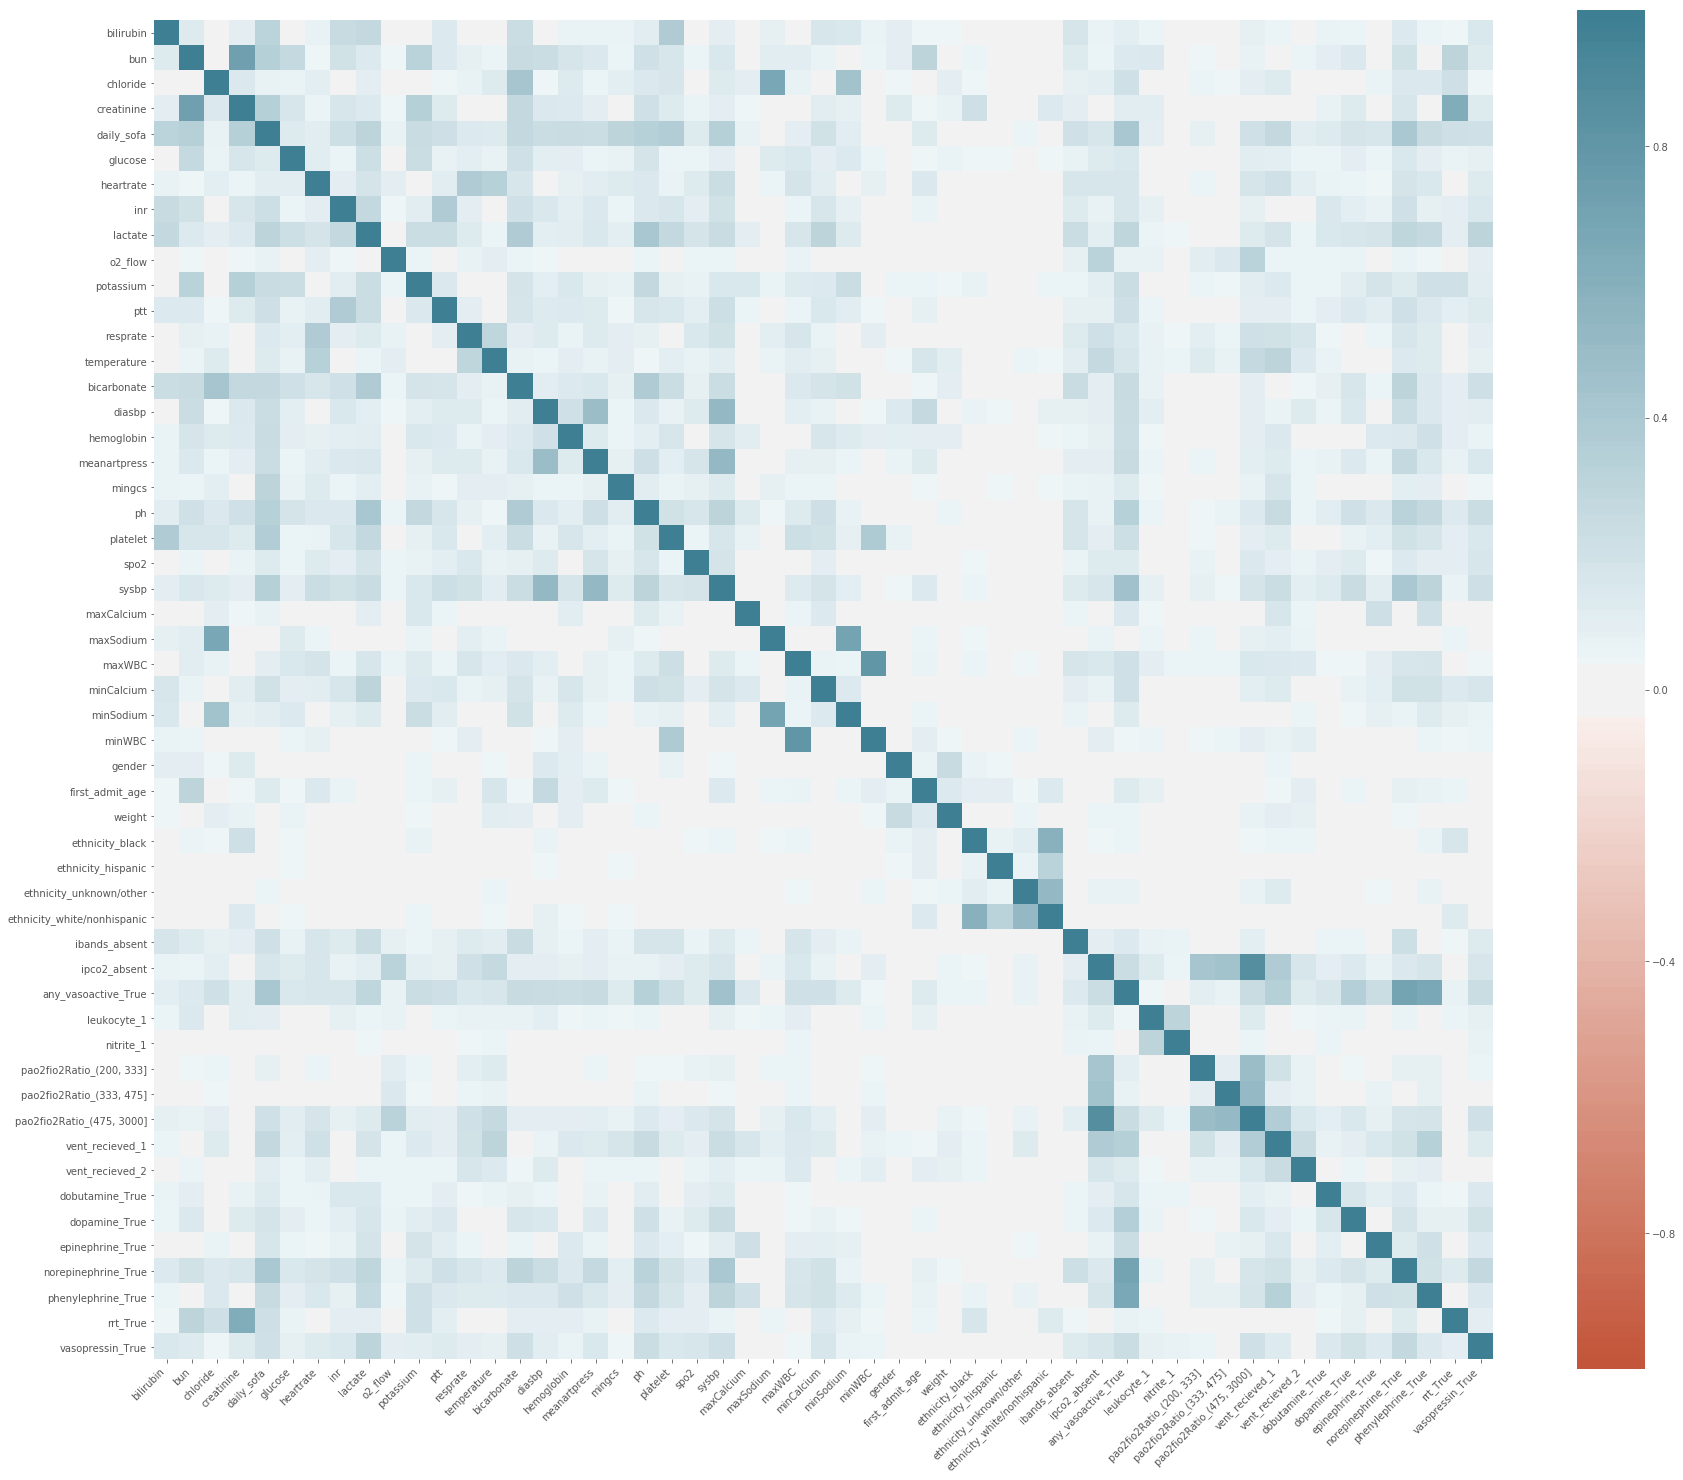

time: 2.18 s


In [19]:
corr = x_train.corr().abs()

plt.figure(figsize=(30, 25))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [20]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2.head()

,corx,cory,corr
0,ipco2_absent,"pao2fio2Ratio_(475, 3000]",0.872418
1,maxWBC,minWBC,0.802373
2,bun,creatinine,0.720861
3,maxSodium,minSodium,0.704233


time: 20.3 ms


### DROPING one of the 2 columns with correlation >0.7

	corx	cory	corr
0	ipco2_absent	pao2fio2Ratio_(475, 3000]	0.872418
1	maxWBC	minWBC	0.802373
2	bun	creatinine	0.720861
3	maxSodium	minSodium	0.704233

In [21]:
x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 5.49 ms


### formatting x and y for modleing

In [22]:
#x=np.array(x_train.iloc[:,[1,2,3,4,5,6,7,8,9,38,39,40,41]]).copy() #copy of x_train
#x=np.array(x_train.iloc[:,[1,2,3,4,5,6,7,8,9]]).copy() #copy of x_train
#x=np.array(x_train.iloc[:,38:])
x=np.array(x_train.copy())

#x=np.array(train_data.iloc[:,[1,2,3,4]]).copy() #copy of x_train
#train_data.iloc[:,[1,2,3,4,5]] ###drastically reducing my dataframe size to test algorithm
y=y_train.copy() #copy of y_train

##all_xy: train data with finalbin:label and index=icustay_id
all_xy=train_data.copy().set_index("icustay_id").rename(columns={'final_bin':"label"}) #

time_interval=4

time: 14.8 ms


# Modelbuilding
* step1) hypertune xgb on 5fold cv.
* step2) test entire trainset and predict trainset.
* step3) run hypertuned model on 5fold cv with lr and get overall metrics.
* step4) local model testing

## step1) XGB hypertuning

In [23]:
# def xgb_hypertuning(scale_pos_weight=1, max_depth=3, n_jobs=4, learning_rate=0.1):
#     skf = StratifiedKFold(n_splits=5) #Stratified K-Folds cross-validator

#     xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
#     xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost
#     cv_y= []

#     for train_index, test_index in skf.split(x, y):

#         xgboost_random = XGBClassifier(learning_rate=learning_rate, n_estimators=100, max_depth=max_depth,
#                                 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                                 objective='binary:logistic', n_jobs=n_jobs, scale_pos_weight=scale_pos_weight, seed=27)
        
#         xgboost_random.fit(x[train_index], y[train_index])
#         y_pred_random = xgboost_random.predict(x[test_index])
#         y_proba_random = xgboost_random.predict_proba(x[test_index])[:,1]

#         xg_one_fold_pred.append(y_pred_random)
#         xg_one_fold_proba.append(y_proba_random)
#         cv_y.append(y[test_index])


#     xg_y_individual_pred = np.array(np.concatenate(xg_one_fold_pred))
#     xg_y_individual_proba = np.array(np.concatenate(xg_one_fold_proba))

#     cv_y_test=np.array(np.concatenate(cv_y))

#     print ('---------new fold---------------')
#     print ('**** result of non-individual predictor using xgboost:')
#     print ('the Accuracy of one fold:', accuracy_score(cv_y_test, xg_y_individual_pred))
#     print ('the AUC of one fold:', roc_auc_score(cv_y_test, xg_y_individual_proba))
#     print(confusion_matrix(cv_y_test, xg_y_individual_pred))
#     print ('the classification_report :\n', classification_report(cv_y_test, xg_y_individual_pred))
#     print("\n")


time: 5.09 ms


In [24]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import log_loss
    
    y_hat = model.predict(test_features)
    errors = abs(y_hat - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    auc=roc_auc_score(test_labels, y_hat)
    loss= log_loss(test_labels, y_hat)
    
    print ('the AUC is: {:0.2f}'.format(auc))
    print ('the logloss is: {:0.2f}'.format(loss))
    print(confusion_matrix(test_labels, y_hat))
    
    return loss


# base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
# base_model.fit(x, y)
# base_auc = evaluate(base_model, x, y)

# best_random = rf_random.best_estimator_
# random_auc = evaluate(best_random, x, y)

# print('Improvement of {:0.2f}%.'.format( 100 * (random_auc - base_auc) / base_auc))

time: 20.3 ms


In [52]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, base_model, scoring="neg_log_loss", gridsearch=True, n_iter=20): 
    if gridsearch==True:
        grid_search = GridSearchCV(estimator= model,
                                         param_grid=param_grid,
                                         cv=nfolds,
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    else:
        grid_search = RandomizedSearchCV(estimator= model,
                                         param_distributions= param_grid,
                                         n_iter=n_iter,
                                         cv=nfolds,
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    grid_search.fit(X, y)    
    
    print("Grid scores on development set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    #grid_search.best_params_
    print(grid_search.best_score_)
    print("\n")
    print(grid_search.best_params_)
    
    print('\n base model (random_state 42):')
    base_model = base_model#(random_state = 42)
    base_model.fit(x, y)
    base_auc = evaluate(base_model, x, y)
    
    print('\n hypertuned model:')
    best_random = grid_search.best_estimator_
    random_auc = evaluate(best_random, x, y)

    print('logloss change of {:0.2f}%. after hypertuning on training set (may be overfit)'.format( 100 * (random_auc - base_auc) / base_auc))
    
    print(grid_search.best_estimator_)
    
    return(grid_search)

time: 51 ms


In [53]:
# test=xg_param_selection(x, y, 5, scoring="balanced_accuracy")
# test=xg_param_selection(x, y, 5, scoring="roc_auc")

time: 705 µs


In [54]:
###xgboost
model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27)
scale_pos_weight = [0.1, 1, 5, 10]
max_depth = [1, 2, 3, 4, 5]
learning_rate=[0.01, 0.1, 0.5, 1]
param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}

base_model=XGBClassifier(random_state = 42)


xgboost_hyper==hypertuning_fxn(x, y, nfolds=5, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=20, gridsearch=True)

NameError: name 'xgboost_hyper' is not defined

time: 15.9 ms


In [369]:
###rf
# Number of trees in random forest
#n_estimators = [100, 1000]#[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,'auto', 10 ]
# Maximum number of levels in tree
max_depth = [5,10, 25]#[int(x) for x in np.linspace(5, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None,{0:1, 1:4}, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]


param_grid = {#'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}


model= RandomForestClassifier(criterion='entropy')
base_model=RandomForestClassifier(random_state = 42, criterion='entropy')

rf_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss",n_iter = 30, gridsearch=True)


Grid scores on development set:
-0.483 (+/-0.022) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
-0.486 (+/-0.028) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
-0.487 (+/-0.026) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
-0.486 (+/-0.025) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
-0.484 (+/-0.018) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
-0.486 (+/-0.027) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 10}
-0.487 (+/-0.019) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
-0.488 (+/-0.024) for {'class_weight': None, 'max_depth': 5, 'max_features':

## Hypertune SVC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# Take the first two features. We could avoid this by using a two-dim dataset
X = x[:,0:2]#iris.data[:, :2]
#y = #iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(list(x_train)[0])
    ax.set_ylabel(list(x_train)[1])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [371]:
model= svm.SVC(probability=True)
kernel = ['linear', 'rbf', 'poly']
gamma = [0.1, 1, 'auto'] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default=’auto’ uses 1 / n_features
C = [0.1, 1, 10, 100] #Penalty parameter C of the error term.
degree = [0, 1, 2]
class_weight=['balanced', None]

param_grid = {'kernel': kernel,
              'gamma': gamma,
              'C': C,
              'degree': degree,
              'class_weight':class_weight}

base_model=svm.SVC(probability=True)

svc_hyper=hypertuning_fxn(x, y, nfolds=4, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=10, gridsearch=False)

Grid scores on development set:
-0.492 (+/-0.035) for {'kernel': 'rbf', 'gamma': 'auto', 'degree': 1, 'class_weight': None, 'C': 0.1}
-0.472 (+/-0.027) for {'kernel': 'linear', 'gamma': 0.1, 'degree': 0, 'class_weight': None, 'C': 0.1}
-0.570 (+/-0.001) for {'kernel': 'poly', 'gamma': 'auto', 'degree': 0, 'class_weight': 'balanced', 'C': 10}
-0.459 (+/-0.025) for {'kernel': 'linear', 'gamma': 1, 'degree': 0, 'class_weight': 'balanced', 'C': 100}
-0.570 (+/-0.001) for {'kernel': 'poly', 'gamma': 0.1, 'degree': 0, 'class_weight': 'balanced', 'C': 10}
-0.570 (+/-0.001) for {'kernel': 'poly', 'gamma': 0.1, 'degree': 0, 'class_weight': 'balanced', 'C': 100}
-0.467 (+/-0.027) for {'kernel': 'linear', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced', 'C': 0.1}
-0.476 (+/-0.021) for {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced', 'C': 100}
-0.461 (+/-0.028) for {'kernel': 'poly', 'gamma': 1, 'degree': 1, 'class_weight': 'balanced', 'C': 1}
-0.463 (+/-0.024) 

# Hypertuned Model Initialization

In [374]:
# xgboost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
#        n_jobs=-1, nthread=None, objective='binary:logistic',
#        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#        seed=27, silent=True, subsample=0.8)
# #xgboost.fit(x, y)

# logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
#                         intercept_scaling=1, class_weight='balanced', random_state=None)

# #logreg.fit(x, y)

# rf= RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 4},
#             criterion='entropy', max_depth=10, max_features='auto',
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=2,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             n_estimators=600, n_jobs=None, oob_score=False,
#             random_state=None, verbose=0, warm_start=False)
# #rf.fit(x,y)

# # from sklearn.naive_bayes import GaussianNB
# # gnb =GaussianNB()
# # nb_y_pred = gnb.fit(x, y)

# svc= svm.SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
#           decision_function_shape='ovr', degree=0, gamma=1, kernel='linear',
#           max_iter=-1, probability=True, random_state=None, shrinking=True,
#           tol=0.001, verbose=False)
# #svc.fit(x, y)

xgboost= xgboost_hyper.best_estimator_

logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                        intercept_scaling=1, class_weight='balanced', random_state=None)

rf= rf_hyper.best_estimator_

svc=svc_hypter.best_estimator_


time: 29 ms


In [50]:
def reset_model(model_name):
    if model_name== 'xgboost':
        model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
           max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
           n_jobs=-1, nthread=None, objective='binary:logistic',
           random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
           seed=27, silent=True, subsample=0.8)
        
        
    elif model_name== 'logreg':
        model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                intercept_scaling=1, class_weight='balanced', random_state=None)

    elif model_name== 'rf':
        model = RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 4},
            criterion='entropy', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
    
    elif model_name== 'svc':
        model = svm.SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
              decision_function_shape='ovr', degree=0, gamma=1, kernel='linear',
              max_iter=-1, probability=True, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
        
    return(model)
#svc.fit(x, y)


# def reset_model(model_name):
#     if model_name== 'xgboost':
#         model = xgboost_hyper.best_estimator_
        
#     elif model_name== 'logreg':
#         model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
#                                 intercept_scaling=1, class_weight='balanced', random_state=None)

#     elif model_name== 'rf':
#         model = rf_hyper.best_estimator_
    
#     elif model_name== 'svc':
#         model = svc_hypter.best_estimator_
#     return(model)
#svc.fit(x, y)

time: 65.8 ms


# run hypertuned model on 5fold cv with lr and get overall metrics.
*<del> step1) hypertune xgb on 5fold cv.

* step2) run hypertuned model on 5fold cv with lr and get overall metrics.
* step3) test entire trainset and predict testset.
* step4) local model testing

In [29]:
def get_auc_score(model,train_index, x=x,y=y):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 2.22 ms


In [30]:
#handwritten cv function
skf = StratifiedKFold(n_splits=5) #Stratified K-Folds cross-validator

xg_cv_auc = [] # xg auc of each cv rep
xg_cv_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_cv_auc = [] # lr auc of each cv rep
lr_cv_proba = [] # obtain the proba  of testing samples for one fold using lr

rf_cv_auc = [] # rf1 auc of each cv rep
rf_cv_proba = [] # obtain the proba  of testing samples for one fold using lr

svc_cv_auc = [] # rf1 auc of each cv rep
svc_cv_proba = [] # obtain the proba  of testing samples for one fold using lr


cv_y= []

for train_index, test_index in skf.split(x, y):   
#     xgboost = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=2,
#                             min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                             objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
    xgboost = reset_model('xgboost')
    xgboost.fit(x[train_index], y[train_index])
    xgboost_auc= get_auc_score(xgboost, x=x,y=y, train_index=train_index)
    xgboost_pred_proba = xgboost.predict_proba(x[test_index])[:, 1]
    
    xg_cv_auc.append(xgboost_auc)
    xg_cv_proba.append(xgboost_pred_proba)
   
    #logistic reg
    logreg= reset_model('logreg')
    logreg.fit(x[train_index], y[train_index])
    logreg_auc= get_auc_score(logreg, x=x,y=y, train_index=train_index)
    logreg_pred_proba = logreg.predict_proba(x[test_index])[:, 1] 
    
    lr_cv_auc.append(logreg_auc)
    lr_cv_proba.append(logreg_pred_proba)
    
    ###random forest: had two very different best hyperparameters via 2 different cv methods.

    rf= reset_model('rf')
    
    rf.fit(x[train_index], y[train_index])
    rf_auc= get_auc_score(rf, x=x,y=y, train_index=train_index)
    rf_pred_proba = rf.predict_proba(x[test_index])[:, 1]   

    rf_cv_auc.append(rf_auc)
    rf_cv_proba.append(rf_pred_proba)
    
    
    svc= reset_model('svc')
    svc.fit(x[train_index], y[train_index])
    svc_auc= get_auc_score(svc, x=x,y=y, train_index=train_index)
    svc_pred_proba = svc.predict_proba(x[test_index])[:, 1] 
    
    svc_cv_auc.append(svc_auc)
    svc_cv_proba.append(svc_pred_proba)
    

    cv_y.append(y[test_index])
    
#xg_cv_auc_all= np.array(np.concatenate(xg_cv_auc))
xg_cv_proba= np.array(np.concatenate(xg_cv_proba))

#lr_cv_auc_all= np.array(np.concatenate(lr_cv_auc))
lr_cv_proba= np.array(np.concatenate(lr_cv_proba))

#rf1_cv_auc_all= np.array(np.concatenate(rf1_cv_auc))
rf_cv_proba= np.array(np.concatenate(rf_cv_proba))

svc_cv_proba= np.array(np.concatenate(svc_cv_proba))


cv_y_test=np.array(np.concatenate(cv_y))
one_fold_y_test = y[test_index]

print(pd.DataFrame({'xg':xg_cv_auc, 'lr':lr_cv_auc, 'rf':rf_cv_auc, 'svc':svc_cv_auc}))

         xg        lr        rf       svc
0  0.924164  0.807457  0.990769  0.805948
1  0.921217  0.800587  0.991189  0.799678
2  0.922717  0.806012  0.989467  0.805489
3  0.926408  0.812142  0.991693  0.811830
4  0.923787  0.801911  0.991595  0.801123
time: 5min 25s


In [298]:
#breaking this up into compartmentalized fxns
#def youden_index(y, y_hat_prob, pos_label=1)
def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=False,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r", label="youden_optimal")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    if save==True:
        if folder_name != None:
            address = 'figures/{}/'.format(folder_name)
        else:
            address = 'figures/'
        if not os.path.exists(address):
            os.makedirs(address)
        plt.savefig(address+"/{}_{}.png".format(model_name,file_name),bbox_inches='tight')
    else: pass
    
    plt.show()
    
def plot_table_as_fig(table_in, col_labels, row_labels, save=False,model_name=None,folder_name=None, file_name=None,figsize=(6,1)):
    
    fig = plt.figure(figsize=figsize)
    table = plt.table(cellText = table_in, 
                  colLabels = col_labels,
                  rowLabels = row_labels,
                  loc='best')
    plt.axis("tight")
    plt.axis('off')
    if save==True:
        if folder_name != None:
            address = 'figures/{}/'.format(folder_name)
        else:
            address = 'figures/'
        if not os.path.exists(address):
            os.makedirs(address)
        plt.savefig(address+"/{}_{}.png".format(model_name,file_name),bbox_inches='tight')
    else: pass
    
    plt.show()
    

def classifier_eval2(y_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True):
    import sklearn.metrics as metrics

    """
    modified classifier_eval except doesn't require a model input, just a y_proba. easier to eval models w/ cv this way
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    this fxn is used to plot the classification model evaluation using both the 0.5 cutoff and the optimal youden cutoff for a given model
    
    """
    y_pred=[1 if y >= 0.5 else 0 for y in y_proba]

    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds)
    
    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx)
    
    #plotting confusion matrixs
   
    print("\n******* Using 0.5 Classification Threshold *******")
    np.set_printoptions(precision=2)
    print(confusion_matrix(y, y_pred))
    #plot_confusion_matrix(y, y_pred, title='Confusion matrix, 0.5 Prob')
#     plt.show()
    print ('the Accuracy is:',accuracy_score(y, y_pred))
    print("npv: ", (confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0))*100)
    print ('the classification_report:\n', classification_report(y,y_pred))


    
    print("\n******* Using Optimal Youden Classification Threshold *******")
    print("the Youden optimal index is : {:01.2f}".format(youden_threshold))
    y_pred_youden= [1 if y >= youden_threshold else 0 for y in y_proba]
    #plt.sca(axarr[0, 2])   
    #plot_confusion_matrix(y, y_pred_youden, title='Confusion matrix, {:01.2f} Prob'.format(youden_threshold))
    print(confusion_matrix(y, y_pred_youden))
    #plt.show()
    
    if print_classification_table==True:
        print ('the Accuracy is:',accuracy_score(y, y_pred_youden))
        print("npv: ", (confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0))*100)
        print ('the classification_report:\n', classification_report(y,y_pred_youden))
    else:
        pass
    

time: 337 ms


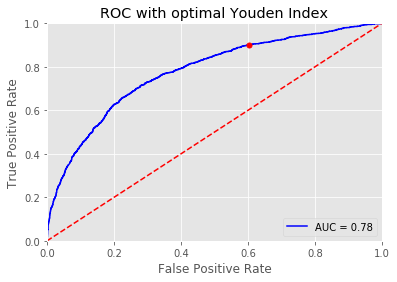


******* Using 0.5 Classification Threshold *******
[[3768  272]
 [ 900  497]]
the Accuracy is: 0.7844399485010116
npv:  80.719794344473
the classification_report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87      4040
           1       0.65      0.36      0.46      1397

   micro avg       0.78      0.78      0.78      5437
   macro avg       0.73      0.64      0.66      5437
weighted avg       0.77      0.78      0.76      5437


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.13
[[1604 2436]
 [ 139 1258]]
the Accuracy is: 0.5263932315615228
npv:  92.02524383247275
the classification_report:
               precision    recall  f1-score   support

           0       0.92      0.40      0.55      4040
           1       0.34      0.90      0.49      1397

   micro avg       0.53      0.53      0.53      5437
   macro avg       0.63      0.65      0.52      5437
weighted avg       0.77

In [32]:
classifier_eval2(y_proba=svc_cv_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

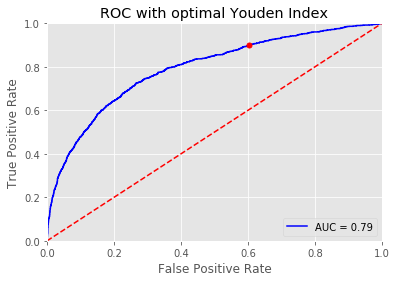


******* Using 0.5 Classification Threshold *******
[[3755  285]
 [ 821  576]]
the Accuracy is: 0.7965789957697259
npv:  82.05856643356644
the classification_report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      4040
           1       0.67      0.41      0.51      1397

   micro avg       0.80      0.80      0.80      5437
   macro avg       0.74      0.67      0.69      5437
weighted avg       0.78      0.80      0.78      5437


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.10
[[1598 2442]
 [ 139 1258]]
the Accuracy is: 0.5252896818098216
npv:  91.99769717904432
the classification_report:
               precision    recall  f1-score   support

           0       0.92      0.40      0.55      4040
           1       0.34      0.90      0.49      1397

   micro avg       0.53      0.53      0.53      5437
   macro avg       0.63      0.65      0.52      5437
weighted avg       0.

In [33]:
#testing classifier_eval2
#fig, axarr = plt.subplots(2, 3)     # 6 axes, returned as a 2-d array
classifier_eval2(y_proba=xg_cv_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)
#plt.show()

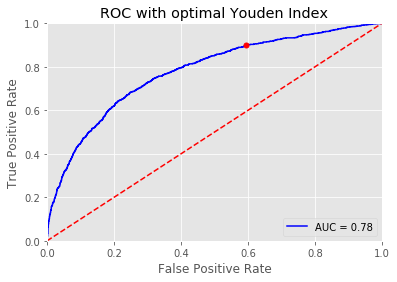


******* Using 0.5 Classification Threshold *******
[[3049  991]
 [ 452  945]]
the Accuracy is: 0.7345962847158359
npv:  87.08940302770637
the classification_report:
               precision    recall  f1-score   support

           0       0.87      0.75      0.81      4040
           1       0.49      0.68      0.57      1397

   micro avg       0.73      0.73      0.73      5437
   macro avg       0.68      0.72      0.69      5437
weighted avg       0.77      0.73      0.75      5437


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.28
[[1644 2396]
 [ 139 1258]]
the Accuracy is: 0.5337502299061982
npv:  92.20415030846887
the classification_report:
               precision    recall  f1-score   support

           0       0.92      0.41      0.56      4040
           1       0.34      0.90      0.50      1397

   micro avg       0.53      0.53      0.53      5437
   macro avg       0.63      0.65      0.53      5437
weighted avg       0.

In [34]:
classifier_eval2(y_proba=lr_cv_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

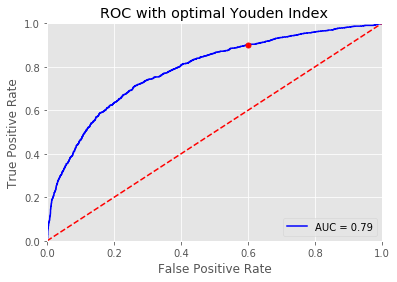


******* Using 0.5 Classification Threshold *******
[[3265  775]
 [ 525  872]]
the Accuracy is: 0.7608975537980504
npv:  86.14775725593667
the classification_report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      4040
           1       0.53      0.62      0.57      1397

   micro avg       0.76      0.76      0.76      5437
   macro avg       0.70      0.72      0.70      5437
weighted avg       0.78      0.76      0.77      5437


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.31
[[1616 2424]
 [ 139 1258]]
the Accuracy is: 0.5286003310649255
npv:  92.07977207977208
the classification_report:
               precision    recall  f1-score   support

           0       0.92      0.40      0.56      4040
           1       0.34      0.90      0.50      1397

   micro avg       0.53      0.53      0.53      5437
   macro avg       0.63      0.65      0.53      5437
weighted avg       0.

In [35]:
classifier_eval2(y_proba=rf_cv_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

# testing global model

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 5fold cv.
    
<del> * step2) run hypertuned model on 5fold cv with lr and get overall metrics.
* step3) test entire train set and predict testset.
* step4) local model testing

In [57]:
# #nicer confusion matrix plot
# def plot_confusion_matrix(y_true, y_pred, #classes,
#                           normalize=False,
#                           title=None,
#                           cmap=plt.cm.Blues):
#     import matplotlib.pyplot as plt
#     from sklearn import datasets
#     from sklearn.model_selection import train_test_split
#     from sklearn.metrics import confusion_matrix
#     from sklearn.utils.multiclass import unique_labels
    
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = unique_labels(y_true, y_pred)
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         #print("Normalized confusion matrix")
#     else:
#         pass
#         #print('Confusion matrix, without normalization')

#     #print(cm)

#     fig, ax = plt.subplots()
#     im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
#     # We want to show all ticks...
#     ax.set(xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            # ... and label them with the respective list entries
#            xticklabels=classes,
#            yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label')
    
#     ax.grid(False) #remove gridlines for readability
    
#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

#     # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
#     return (ax)


time: 63.9 ms


thresholds: 
* Decreasing thresholds on the decision function used to compute
    fpr and tpr. `thresholds[0]` represents no instances being predicted
    and is arbitrarily set to `max(y_score) + 1`.


In [37]:
#setting up test table

#print(pd.DataFrame({'xg':xg_cv_auc, 'lr':lr_cv_auc, 'rf':rf_cv_auc, 'svc':svc_cv_auc}))
#pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[]})
test_summary_df= pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[], 'npv':[]})
test_summary_df

,model,auc,precision,recall,f1,npv


time: 7.59 ms


In [303]:
def classifier_eval(model, x=x, y=y, pos_label=1, print_default=True, save=False,model_name=None, folder_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    """
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    this fxn is used to plot the classification model evaluation using both the 0.5 cutoff and the optimal youden cutoff for a given model
    
    """
    if save==True:
        if folder_name != None:
            address = '../figures/{}/'.format(folder_name)
        else:
            address = 'train/'
        if not os.path.exists(address):
            os.makedirs(address)
    
    
    model_name=type(model).__name__
    
    y_pred = model.predict(x)
    y_proba = model.predict_proba(x)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True )
    
    #plotting roc
    
    plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save, model_name=model_name,folder_name=folder_name, file_name='roc')
    plt.show(), plt.close()
    
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)*100
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: 
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.2f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.2f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred))
    else:
        pass
    
    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.2f}".format(youden_threshold))

    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)*100
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
    
    ##plotting and saving confusion matrix
    confusion_youden=confusion_matrix(y, y_pred_youden)
    plot_table_as_fig(confusion_youden,
                  col_labels=['predicted_neg','predicted_pos'],
                  row_labels=['true_neg',"true_pos"],
                  save=save,
                  figsize=(6,1),
                  model_name=model_name,
                  folder_name=folder_name,
                  file_name='y_confusion')
    plt.show(), plt.close()
   
    #print(confusion_matrix(y, y_pred_youden))
    print("the Accuracy is: {:01.2f}".format(accuracy_score(y, y_pred_youden)))
    print("npv: {:01.2f}".format(npv_y))
    
    report_youden=classification_report(y,y_pred_youden)
    
    
    report_youden=classification_report(y, xgboost.predict(x),output_dict=True)
    report_youden = pd.DataFrame.from_dict(report_youden).transpose()[['precision','recall','f1-score','support']]
    report_youden= np.round(df,2)

    
    ##plotting and saving classification report
    plot_table_as_fig(table_in=np.array(report_youden),#classification_report(y, xgboost.predict(x))),
                      col_labels=['precision','recall','f1-score','support'],
                      row_labels=['neg',"pos","micro_avg","macro_avg",'weighted_avg'],
                      figsize=(15,5),
                      save=save,
                      model_name=model_name,
                      folder_name=folder_name,
                      file_name='y_report')
    plt.show(), plt.close()
    
          
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    
    return(youden_dic)
    

time: 239 ms


In [ ]:
# # Helper function to draw confusion matrix
# def confusion_matrix(save=True, folder_name=None):
#     """
#     modified fxn so that if save=True will save the triple_plots, can specify folder to save in too
#     """
    
#     if save==True:
#         if folder_name != None:
#             address = 'train/{}/'.format(folder_name)
#         else:
#             address = 'train/'
#         if not os.path.exists(address):
#             os.makedirs(address)
    
#     os.makedirs('train', exist_ok=True)

#     if save==True:
#         plt.savefig(os.path.join(address, 'confusion-%05d.png' % (i)))
#     else:
#         pass
#     plt.show(), plt.close()

### model fitting

In [59]:
xgboost = reset_model('xgboost')
xgboost.fit(x, y)

logreg = reset_model('logreg')
logreg.fit(x, y)

rf= reset_model('rf')
rf.fit(x,y)

# from sklearn.naive_bayes import GaussianNB
# gnb =GaussianNB()
# nb_y_pred = gnb.fit(x, y)

from sklearn import svm
svc= reset_model('svc')
svc.fit(x, y)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=0, gamma=1, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

time: 1min 33s


### global model test set evaluation

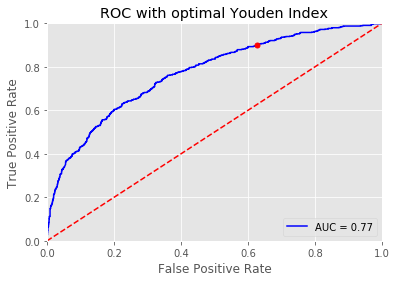


******* Using 0.5 Classification Threshold *******

[[1266  417]
 [ 230  415]]
the Accuracy is: 0.72
npv: 84.63
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80      1683
           1       0.50      0.64      0.56       645

   micro avg       0.72      0.72      0.72      2328
   macro avg       0.67      0.70      0.68      2328
weighted avg       0.75      0.72      0.73      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.13


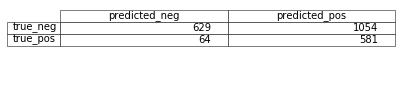

the Accuracy is: 0.52
npv: 90.76


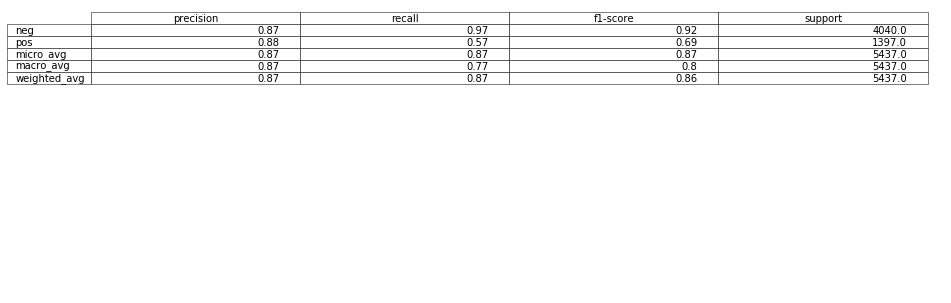

time: 1.46 s


In [305]:
svc_eval= classifier_eval(svc, x=np.array(x_test), y=y_test, save=True, model_name='svc', folder_name='clinical_agg')

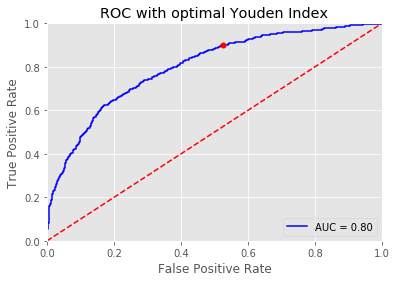


******* Using 0.5 Classification Threshold *******

[[1563  120]
 [ 387  258]]
the Accuracy is: 0.78
npv: 80.15
the classification_report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      1683
           1       0.68      0.40      0.50       645

   micro avg       0.78      0.78      0.78      2328
   macro avg       0.74      0.66      0.68      2328
weighted avg       0.77      0.78      0.76      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.13


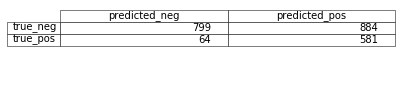

the Accuracy is: 0.59
npv: 92.58


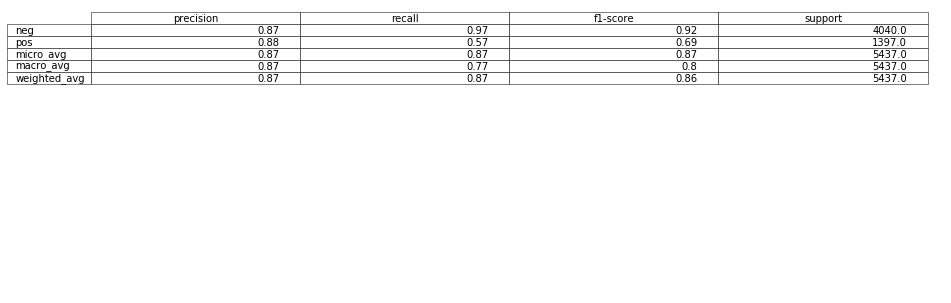

time: 1.13 s


In [306]:
xgboost_eval= classifier_eval(xgboost, x=np.array(x_test), y=y_test, save=True, model_name='xgboost', folder_name='clinical_agg')

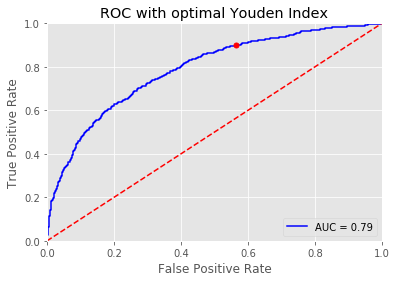


******* Using 0.5 Classification Threshold *******

[[1343  340]
 [ 240  405]]
the Accuracy is: 0.75
npv: 84.84
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82      1683
           1       0.54      0.63      0.58       645

   micro avg       0.75      0.75      0.75      2328
   macro avg       0.70      0.71      0.70      2328
weighted avg       0.76      0.75      0.76      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.33


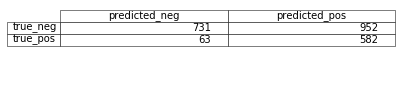

the Accuracy is: 0.56
npv: 92.07


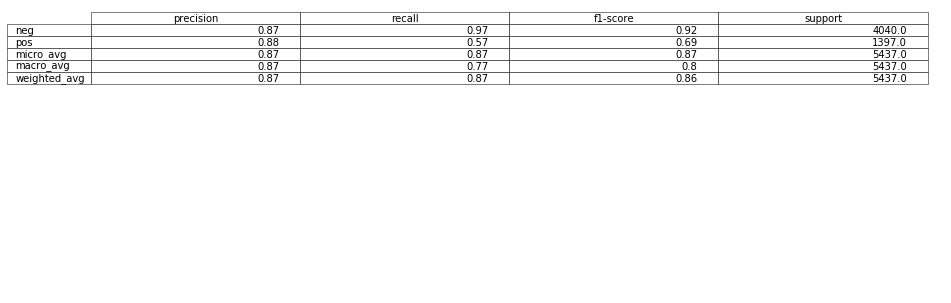

time: 1.83 s


In [307]:
rf_eval= classifier_eval(rf, x=np.array(x_test), y=y_test, save=True, model_name='rf', folder_name='clinical_agg')

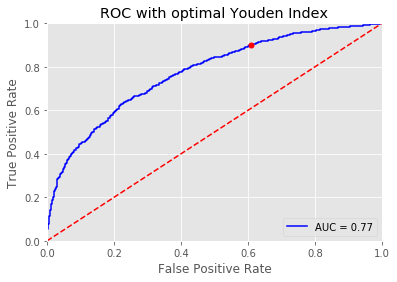


******* Using 0.5 Classification Threshold *******

[[1239  444]
 [ 215  430]]
the Accuracy is: 0.72
npv: 85.21
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79      1683
           1       0.49      0.67      0.57       645

   micro avg       0.72      0.72      0.72      2328
   macro avg       0.67      0.70      0.68      2328
weighted avg       0.75      0.72      0.73      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.28


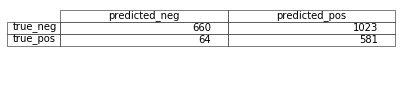

the Accuracy is: 0.53
npv: 91.16


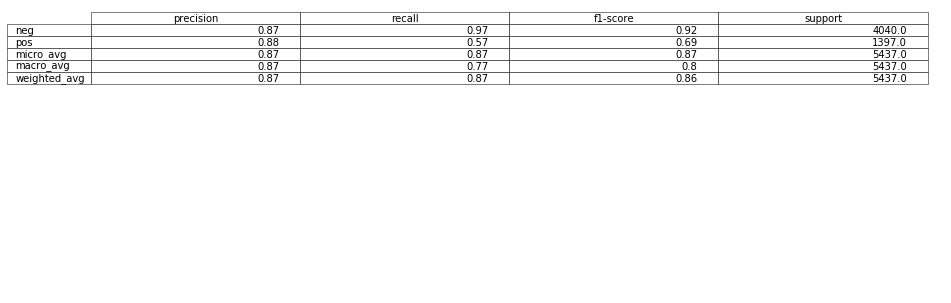

time: 1.22 s


In [308]:
# logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test)
logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test, save=True, model_name='logreg', folder_name='clinical_agg')

In [309]:
#classifier_eval(gnb, x=x_test, y=y_test)
test_summary_df= pd.DataFrame([rf_eval,
                             logreg_eval,
                             xgboost_eval,
                             svc_eval])
test_summary_df.set_index('model').round(decimals=2)

,auc,f1,npv,precision,recall
model,,,,,
RandomForestClassifier,0.79,0.53,92.07,0.38,0.9
LogisticRegression,0.77,0.52,91.16,0.36,0.9
XGBClassifier,0.80,0.55,92.58,0.40,0.9
SVC,0.77,0.51,90.76,0.36,0.9


time: 15.5 ms


In [68]:
test_summary_df= pd.DataFrame([rf_eval,
                             logreg_eval,
                             xgboost_eval,
                             svc_eval])
test_summary_df.set_index('model').round(decimals=2)

,auc,f1,npv,precision,recall
model,,,,,
RandomForestClassifier,0.79,0.53,92.07,0.38,0.9
LogisticRegression,0.77,0.52,91.16,0.36,0.9
XGBClassifier,0.80,0.55,92.58,0.40,0.9
SVC,0.77,0.51,90.76,0.36,0.9


time: 13.2 ms


# variable importance

In [47]:
def var_imp(model):
    imp= model.feature_importances_
    var_index=[ x for x in range(0,len(rf.feature_importances_))]
    variables=list(x_train)
    return(pd.DataFrame({"imp":imp, 'index':var_index, 'variable': variables}).sort_values('imp', ascending=False))

time: 2.84 ms


In [48]:
var_imp(rf)

,imp,index,variable
12,0.081846,12,temperature
3,0.065511,3,daily_sofa
21,0.059322,21,sysbp
5,0.047838,5,heartrate
11,0.046898,11,resprate
13,0.040942,13,bicarbonate
4,0.039548,4,glucose
16,0.038473,16,meanartpress
45,0.034000,45,norepinephrine_True
25,0.033830,25,minWBC


time: 78.4 ms


In [49]:
var_imp(xgboost)

,imp,index,variable
45,0.139670,45,norepinephrine_True
3,0.088163,3,daily_sofa
33,0.042682,33,ibands_absent
35,0.038087,35,leukocyte_1
12,0.035225,12,temperature
13,0.030492,13,bicarbonate
5,0.027449,5,heartrate
21,0.025856,21,sysbp
11,0.024663,11,resprate
36,0.023238,36,nitrite_1


time: 54 ms


# tSNE visualization

In [460]:
from __future__ import print_function
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

time: 21.3 ms


In [457]:
from sklearn.manifold import TSNE
#X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(x)
X_embedded.shape

(5437, 2)

time: 48.3 s


In [458]:
X_embedded

array([[-45.71, -31.31],
       [-49.33,  43.3 ],
       [ 42.5 ,  51.41],
       ...,
       [-17.76, -58.77],
       [ 51.73,  -2.6 ],
       [-56.87,   1.36]], dtype=float32)

time: 2.82 ms


In [514]:
x_full=pd.concat([x_train,x_test])
y_full=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_test)])

time: 6.54 ms


In [494]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7765 samples in 0.012s...
[t-SNE] Computed neighbors for 7765 samples in 5.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7765
[t-SNE] Computed conditional probabilities for sample 2000 / 7765
[t-SNE] Computed conditional probabilities for sample 3000 / 7765
[t-SNE] Computed conditional probabilities for sample 4000 / 7765
[t-SNE] Computed conditional probabilities for sample 5000 / 7765
[t-SNE] Computed conditional probabilities for sample 6000 / 7765
[t-SNE] Computed conditional probabilities for sample 7000 / 7765
[t-SNE] Computed conditional probabilities for sample 7765 / 7765
[t-SNE] Mean sigma: 0.619672
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.626884
[t-SNE] KL divergence after 300 iterations: 2.705199
t-SNE done! Time elapsed: 40.59568476676941 seconds
time: 40.6 s


In [561]:
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(x_subset)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 0.021636962890625 seconds
time: 24.8 ms


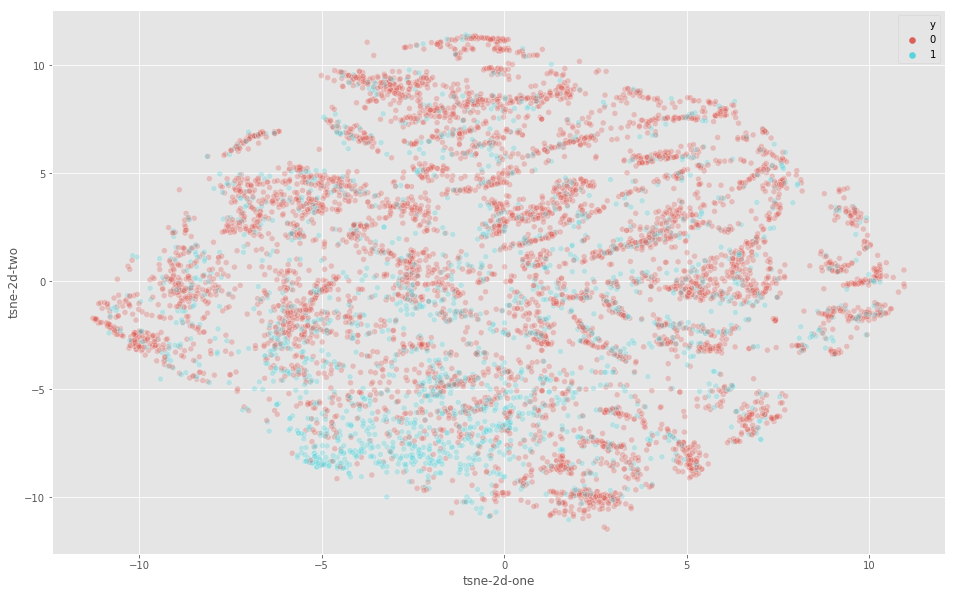

time: 789 ms


In [569]:
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='y',
                palette=sns.color_palette("hls", 2),
                data=tsne_df,
                legend="full",
                alpha=0.3
)

# abandoned: making a classifier scorer method which 
* at first (#1) will try to maximize the accuracy at optimal youden index classification threshold.  
* once above works, will try to minimize the difference between (min(diagonal)-max(offdiagonal)) of confusion matrix.

this will be used in cv to best hyperparameterize

score_func : callable,
Score function (or loss function) with signature score_func(y, y_pred, **kwargs).

In [ ]:
# def youden_scorer(y, y_pred, pos_label=1):
#     #y_proba, x=x, y=y, pos_label=1
#     import sklearn.metrics as metrics
    
#     y_proba=y_pred.copy()
#     fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
#     roc_auc = metrics.auc(fpr, tpr)

#     #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
#     youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds) #can optimize by removing roc_df, idx
#     del(roc_df, idx)
    
#     #******* Using Optimal Youden Classification Threshold *******
#     y_pred= [1 if y >= youden_threshold else 0 for y in y_proba]
#     accuracy_score=accuracy_score(y, y_pred)
#     return(accuracy_score)


In [ ]:
# from sklearn.metrics import make_scorer
# scorer=make_scorer(youden_scorer)

# scores = cross_val_score(rf_random, x, y, cv=5, scoring= scorer)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state = 2)
# clf.fit(X_train,y_train)
# # y_pred = clf.predict(X_test)  # default threshold is 0.5
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3

In [ ]:
# y_pred_random = rf_y_individual_pred
# y_proba_random = rf_y_individual_proba
# fpr, tpr, thresholds = metrics.roc_curve(y, rf_y_individual_proba, pos_label=1)
# #fpr, tpr, thresholds = metrics.roc_curve(y, rf_y_individual_proba, pos_label=1)
# roc_auc = metrics.auc(fpr, tpr)

# #making dataframe out of the thresholds
# xgb_roc= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
# xgb_roc.iloc[0,0] =1
# xgb_roc['yuden']= xgb_roc['tpr']-xgb_roc['fpr']
# idx=xgb_roc['yuden'].idxmax()
# xgb_roc.iloc[idx,:]
# youden_threshold=xgb_roc.iloc[idx,0]

# roc_auc = metrics.auc(fpr, tpr)

# plt.title('ROC with optimal Youden Index')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.plot(xgb_roc.iloc[idx,1], xgb_roc.iloc[idx,2],marker='o', markersize=5, color="r", label="youden_optimal")
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()


# #plotting confusion matrixs
# print("\n******* Using 0.5 Classification Threshold *******\n")
# np.set_printoptions(precision=2)
# plot_confusion_matrix(y, y_pred_random, title='Confusion matrix, 0.5 Prob')
# plt.show()
# print ('the Accuracy is:',accuracy_score(y, y_pred_random))
# print ('the classification_report:\n', classification_report(y,y_pred_random))


# print("\n******* Using Optimal Youden Classification Threshold *******\n")
# print("\nthe Youden optimal index is : {:01.2f}".format(youden_threshold))
# y_pred_random_youden=y_proba_random.copy()
# y_pred_random_youden[y_pred_random_youden>=youden_threshold]=1
# y_pred_random_youden[y_pred_random_youden<youden_threshold]=0
# plot_confusion_matrix(y, y_pred_random_youden, title='Confusion matrix, {:01.2f} Prob'.format(youden_threshold))
# plt.show()
# print ('the Accuracy is:',accuracy_score(y, y_pred_random_youden))
# print ('the classification_report:\n', classification_report(y,y_pred_random_youden))

In [ ]:
# #trying different cv algorithm

# from sklearn.model_selection import cross_val_score
# #clf = svm.SVC(kernel='linear', C=1)
# rf_random= RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=4, min_samples_split=2)

# #making roc a scorer
# from sklearn.metrics import make_scorer
# scorer=make_scorer(roc_auc_score)

# scores = cross_val_score(rf_random, x, y, cv=5, scoring= scorer)
# scores     

## local model testing
*<del> step1) hypertune xgb on 5fold cv.

*<del> step2) test entire trainset and predict trainset.
    
*<del> step3) run hypertuned model on 5fold cv with lr and get overall metrics.
* step4) local model testing

In [ ]:
z_icustay_id

In [ ]:
def single_split_training(m=250, n_sfk_split=5):
       
    #######
    skf = StratifiedKFold(n_splits=n_sfk_split) #Stratified K-Folds cross-validator
    num_fold = 0
    
    for train_index, test_index in skf.split(x, y):
        X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
        y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold
    
    #######

        num_fold = num_fold + 1 ##silly to keep but it's from the loop
        print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 

        print('the number of testing samples in this fold:', test_index.size)

        train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
        test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

        xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
        xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

        lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
        lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

        ######
    
        indicator_time = 0 # the indicator
        for i, j in zip(test_z_icustay_id, test_index):  #looping through the zipped indicies of the test indicies/test icustay_id

            testing_sample_id = i #numerical index of first 1/2 of data ##??? this seems to be instead the    
            all_xy_0 = all_xy.loc[train_z_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
            all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

            ###important parameter. was at 400, i changed to X
            m = m  # m is the number of similar cases or similar controls

            X_test_00 = x[j]
            y_test = y[j]

            X_test = X_test_00.reshape(1, -1)

            # print 'start selecting......'

            Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization

            ix = np.isin(z_icustay_id, Id_train_set)
            Id_train_set_index = list(np.where(ix))

            # Id_train_set_index = np.argwhere(z_icustay_id == Id_train_set)

            X_train = x[Id_train_set_index]
            y_train = y[Id_train_set_index]

            #print('start training......')

            # scoring = 'roc_auc'

        # xgboost
        
            #hyper parameter tuning F1 from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 5}
            #hyper parameter tuning F1_macro from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 4, 'scale_pos_weight': 1}
            #hyper parameter tuning recall_macro from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 5}
            #hyper parameter tuning neg_log_loss from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 2, 'scale_pos_weight': 1}


            xgboost_mod = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=2,
                          min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic', nthread=-1, scale_pos_weight=1, seed=27)
            xgboost_mod.fit(x[Id_train_set_index], y[Id_train_set_index])
            xg_y_pred = xgboost_mod.predict(X_test)
            xg_y_pred_proba = xgboost_mod.predict_proba(X_test)[:,1]

            xg_one_fold_pred.append(xg_y_pred)
            xg_one_fold_proba.append(xg_y_pred_proba)

        # lr 

            logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                        intercept_scaling=1, class_weight='balanced', random_state=None)
            logreg.fit(x[Id_train_set_index], y[Id_train_set_index])
            lr_y_pred = logreg.predict(X_test)
            lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

            lr_one_fold_pred.append(lr_y_pred)
            lr_one_fold_proba.append(lr_y_pred_proba)

            indicator_time = indicator_time + 1
            # print 'the next testing sample and total samples:', indicator_time, test_index.size

        xg_y_individual_pred = np.array(xg_one_fold_pred)
        xg_y_individual_proba = np.array(xg_one_fold_proba)

        lr_y_individual_pred = np.array(lr_one_fold_pred)
        lr_y_individual_proba = np.array(lr_one_fold_proba)

        one_fold_y_test = y[test_index]

        print ('---------new fold---------------')
        print ('**** result of non-individual predictor using xgboost:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], xg_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], xg_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], xg_y_individual_pred))
        print(confusion_matrix(y[test_index], xg_y_individual_pred))
        print("\n")

        print ('****this is the result of individual predictor using lr:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
        print(confusion_matrix(y[test_index], lr_y_individual_pred))
        print("\n")

In [ ]:
#do we have multiple models for each patient? if so how do we aggregate?

In [ ]:
single_split_training(m=250,n_sfk_split=2 )

In [ ]:
single_split_training(m=500,n_sfk_split=2 )

In [609]:
# testing the select train set fxn:
icustay_id= z_icustay_id

m=200
#######
skf = StratifiedKFold(n_splits=4) #Stratified K-Folds cross-validator
num_fold = 0

for train_index, test_index in skf.split(x, y):
    X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
    y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

    num_fold = num_fold + 1 ##silly to keep but it's from the loop
    print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
    print('the number of testing samples in this fold:', test_index.size)

    train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    ######

    indicator_time = 0 # the indicator
    ##looping through the zipped indicies of the test_icustay and test row index.
    for i, j in zip(test_icustay_id, test_index): 

        #these three lines: for each sample in the test set individually, go through and add the test sample to the training data.
        testing_sample_id = i #   
        all_xy_0 = all_xy.loc[train_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
        all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

        
        
        ###important parameter. was at 400, i changed to X
        m = m  # m is the number of similar cases or similar controls

        X_test_00 = x[j]
        y_test = y[j]

        X_test = X_test_00.reshape(1, -1)

        # print 'start selecting......'

        Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization

this is the results of the 1 fold in 5 folds:
the number of testing samples in this fold: 1360


IndexError: index 0 is out of bounds for axis 0 with size 0

time: 140 ms


In [ ]:
#trying to collapse to get just 1 cv split index

skf = StratifiedKFold(n_splits=4, random_state=12345) #Stratified K-Folds cross-validator
num_fold = 0

#train_index, test_index in skf.split(x, y):

#splitting_test= skf.split(x,y)
#splitting_test.split(X, y[, groups])
for train_index, test_index in skf.split(x, y):
    print(train_index, test_index)
print(train_index, test_index)
    
#     X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
#     y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

#     num_fold = num_fold + 1 ##silly to keep but it's from the loop
#     print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
#     print('the number of testing samples in this fold:', test_index.size)

#     train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
#     test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

#     xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
#     xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

#     lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
#     lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

In [ ]:
for train_index, test_index in skf.split(x, y):
    X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
    y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

    num_fold = num_fold + 1 ##silly to keep but it's from the loop
    print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
    print('the number of testing samples in this fold:', test_index.size)

    train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

In [576]:
skf = StratifiedKFold(n_splits=4, random_state=12345) #Stratified K-Folds cross-validator
for train_index, test_index in skf.split(x, y):
    pass
train_index
test_index

array([4064, 4065, 4066, ..., 5434, 5435, 5436])

time: 5.73 ms


In [579]:
X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

train_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
test_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold


indicator_time = 0 # the indicator
##looping through the zipped indicies of the test_icustay and test row index.
for testing_sample_id, testing_index_id in zip(test_icustay_id, test_index): 

    #these 2 lines: for each sample in the test set individually, go through and add the test sample to the training data.
    all_xy_0 = all_xy.loc[train_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
    all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 
    
#     ###important parameter. was at 400, i changed to X
#     m = m  # m is the number of similar cases or similar controls

    X_test = x[testing_index_id].reshape(1,-1) #changed x_test_00 to this and made it more easy to understand. array[[xtest]]. 
                                #single sample being tested for
    y_test = y[testing_index_id] #the y label

time: 15.1 s


In [581]:
testing_sample_id

299995

time: 1.73 ms


In [587]:
#299995 in all_xy_training.index#.loc[299995,:]

False

time: 2.21 ms


In [602]:
m=200

#so gets the 200 closest training and 200 closest grower testing samples
Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  
    #testing_sample_id: so all testing 
    #all_xy_training:all training rows except with the single test sample appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of 200 closest training and 200 closest grower testing samples
    
ix = np.isin(z_icustay_id, Id_train_set) #boolean vector where TRUE = for the m * 2 samples
# Id_train_set_index = list(np.where(ix))
# Id_train_set_index = np.argwhere(z_icustay_id == Id_train_set)

X_train = x[ix]# x[Id_train_set_index]
y_train = y[ix]# y[Id_train_set_index]

IndexError: index 0 is out of bounds for axis 0 with size 0

time: 41.9 ms


In [608]:
select_train_samples(testing_sample_id, all_xy_training, m, time_interval)

IndexError: index 0 is out of bounds for axis 0 with size 0

time: 34.1 ms


In [606]:
#all_xy_training #2719
#testing_sample_id in all_xy_training.index

True

time: 2.27 ms


In [601]:
time_interval = 24  # ,48,72,96,120,144]:
#x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
num_splits=2
skf = StratifiedKFold(n_splits=num_splits)
num_fold = 0
for train_index, test_index in skf.split(x, y):
    print ('***************')
    # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
    X_train_0, X_test_0 = x[train_index], x[test_index]
    y_train_0, y_test_0 = y[train_index], y[test_index]

    print( '#####################')

    num_fold = num_fold + 1
    print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

    print ('the number of testing samples in this fold:', test_index.size)

    train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    indicator_time = 0 # the indicator
    for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

        all_xy_cv = all_xy.loc[train_z_icustay_id] # select training samples from  5 fold
        all_xy_training = all_xy_cv.append(all_xy.loc[testing_sample_icu]) # note that , containing the i
        

        m = 200  # m is the number of similar cases or similar controls

        X_test = x[testing_sample_index].reshape(1, -1)
        y_test = y[testing_sample_index]

        # print 'start selecting......'

        Id_train_set = select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)  #  individulization
        """
        #testing_sample_icu: so all testing icu's
        #all_xy_training:all training rows except with the single test sample appended
        #m: #
        #time_interval:w/e
        ##output: icustay_id of 200 closest training and 200 closest grower testing samples
        """
        ix = np.isin(z_icustay_id, Id_train_set)
        X_train=x[ix]# parameters for m*2 training set
        y_train=y[ix]# labels for m*2 training set
        
        ######modeling####
        
        ###logistic regression
        

        logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                    intercept_scaling=1, class_weight='balanced', random_state=None)
        logreg.fit(X_train, y_train)
        lr_y_pred = logreg.predict(X_test)
        lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

        lr_one_fold_pred.append(lr_y_pred)
        lr_one_fold_proba.append(lr_y_pred_proba)

        indicator_time = indicator_time + 1
    
    lr_y_individual_pred = np.array(lr_one_fold_pred)
    lr_y_individual_proba = np.array(lr_one_fold_proba)
    
    one_fold_y_test = y[test_index]
    print ('****this is the result of individual predictor using lr:')
    print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
    print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
    print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
    print(confusion_matrix(y[test_index], lr_y_individual_pred))


***************
#####################
this is the results of the 1 fold in 2 folds:
the number of testing samples in this fold: 2719


IndexError: index 0 is out of bounds for axis 0 with size 0

time: 177 ms


In [ ]:
def local_model(num_splits=2, m=200):
    
    """
    algorithm: first split into train and test set for cv: 
        now have full x, full y, xtrain/ytrain, xtest/ytest for each cv split.
        
        loop through each row in xtest:
            take the current xtest iteration and add it to all xtrain.
            find the M closest other rows based on grower distance.
            take these M rows and train a model on their features and outcome.
            use this model to predict the current xtest iteration. 
            add this prediction to a datastructure
    
    """
    
    time_interval = 24  # ,48,72,96,120,144]:
    #x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
    #num_splits=5
    skf = StratifiedKFold(n_splits=num_splits)
    num_fold = 0
    for train_index, test_index in skf.split(x, y):
        print ('***************')
        # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
        X_train_0, X_test_0 = x[train_index], x[test_index]
        y_train_0, y_test_0 = y[train_index], y[test_index]

        print( '#####################')

        num_fold = num_fold + 1
        print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

        print ('the number of testing samples in this fold:', test_index.size)

        train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
        test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

        xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
        xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

        lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
        lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr
        
        lr_all_pred= []
        lr_all_proba= []

        indicator_time = 0 # the indicator
        for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

            xy_cv = all_xy.iloc[train_index] # select training samples from  5 fold
            xy_training = xy_cv.append(xy_cv.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

            #the clinical data for the single test sample in current iteration.
            X_test = x[testing_sample_index].reshape(1, -1) #single 
            y_test = y[testing_sample_index]
            if indicator_time%50==0:
                print("indicator_time:",indicator_time)
            else:
                pass

            Id_train_set = select_train_samples(testing_sample_icu, xy_training, m, time_interval)  #  individulization
            """
            #testing_sample_icu: single icustay_id of a patient.
            #all_xy_training:all training rows except with the single test sample in question appended
            #m: #
            #time_interval:w/e
            ##output: icustay_id of M closest training and M closest grower testing samples
            """
            ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
            X_train=x[ix]# parameters for m*2 training set
            y_train=y[ix]# labels for m*2 training set
            
            if indicator_time%50==0:
                print("x_train, y_train len:",len(X_train), len(y_train))
            else:
                pass

            ######modeling####

            ###logistic regression


            logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                        intercept_scaling=1, class_weight='balanced', random_state=None)
            logreg.fit(X_train, y_train)
            lr_y_pred = logreg.predict(X_test)
            lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

            lr_one_fold_pred.append(lr_y_pred)
            lr_one_fold_proba.append(lr_y_pred_proba)
            
            lr_all_pred.append(lr_y_pred)
            lr_all_proba.append(lr_y_pred_proba)

            indicator_time = indicator_time + 1

        lr_y_individual_pred = np.array(lr_one_fold_pred)
        lr_y_individual_proba = np.array(lr_one_fold_proba)

        print ('****this is the result of individual predictor using lr:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
        print(confusion_matrix(y[test_index], lr_y_individual_pred))


In [597]:
#trying to implement without cv.   
time_interval = 24  # ,48,72,96,120,144]:

m=200

train_z_icustay_id = z_icustay_id # the icustay_id of samples in training set from 5 fold
test_z_icustay_id = z_icustay_id # the icustay_id of samples in testing set from 5 fold

xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

lr_all_pred= []
lr_all_proba= []

indicator_time = 0 # the indicator
for testing_sample_icu, testing_sample_index in zip(z_icustay_id, range(0,len(z_icustay_id))):

#     xy_cv = all_xy.drop(train_index, axis=0) # select training samples from  5 fold
#     xy_training = xy_cv.append(xy_cv.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

    #the clinical data for the single test sample in current iteration.
    X_test = x[testing_sample_index].reshape(1, -1) #single 
    y_test = y[testing_sample_index]
    if indicator_time%50==0:
        print("indicator_time:",indicator_time)
    else:
        pass

    Id_train_set = select_train_samples(testing_sample_icu, all_xy, m, time_interval)  #  individulization
    """
    #testing_sample_icu: single icustay_id of a patient.
    #all_xy_training:all training rows except with the single test sample in question appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of M closest training and M closest grower testing samples
    """
    ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
    X_train=x[ix]# parameters for m*2 training set
    y_train=y[ix]# labels for m*2 training set

    ######modeling####

    ###logistic regression


    logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                intercept_scaling=1, class_weight='balanced', random_state=None)
    logreg.fit(X_train, y_train)
    lr_y_pred = logreg.predict(X_test)
    lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

    lr_one_fold_pred.append(lr_y_pred)
    lr_one_fold_proba.append(lr_y_pred_proba)

    lr_all_pred.append(lr_y_pred)
    lr_all_proba.append(lr_y_pred_proba)
    
    indicator_time = indicator_time + 1

lr_y_individual_pred = np.array(lr_one_fold_pred)
lr_y_individual_proba = np.array(lr_one_fold_proba)

print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y, lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y, lr_y_individual_pred))
print ('the classification_report :', classification_report(y, lr_y_individual_pred))
print(confusion_matrix(y, lr_y_individual_pred))

indicator_time: 0


IndexError: index 0 is out of bounds for axis 0 with size 0

time: 105 ms


In [598]:
z_icustay_id

0       200012
1       200014
2       200033
3       200036
4       200059
5       200063
6       200078
7       200091
8       200099
9       200108
10      200116
11      200141
12      200150
13      200188
14      200215
15      200231
16      200249
17      200265
18      200269
19      200312
20      200325
21      200328
22      200349
23      200350
24      200352
25      200361
26      200398
27      200399
28      200417
29      200439
         ...  
5407    299445
5408    299457
5409    299482
5410    299490
5411    299495
5412    299529
5413    299543
5414    299593
5415    299630
5416    299645
5417    299655
5418    299715
5419    299728
5420    299736
5421    299751
5422    299765
5423    299767
5424    299806
5425    299811
5426    299828
5427    299832
5428    299858
5429    299883
5430    299888
5431    299903
5432    299913
5433    299914
5434    299950
5435    299994
5436    299995
Name: icustay_id, Length: 5437, dtype: int64

time: 4.03 ms


In [596]:
select_train_samples(testing_sample_icu, all_xy, m, time_interval)

IndexError: index 0 is out of bounds for axis 0 with size 0

time: 30.3 ms


In [595]:
testing_sample_icu in all_xy.index

True

time: 2.15 ms


In [ ]:
m

In [ ]:
print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y, lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y, lr_y_individual_pred))
print ('the classification_report :', classification_report(y, lr_y_individual_pred))
print(confusion_matrix(y, lr_y_individual_pred))

In [ ]:
classifier_eval2(y_proba=lr_y_individual_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

In [ ]:
all_xy.iloc[-5]

In [ ]:


#Id_train_set

#Id_train_set.isin(z_icustay_id[train_index])

len(set(Id_train_set) & set(z_icustay_id[train_index]))  #400

# len(set(Id_train_set) & set(z_icustay_id[test_index]))  #0

# #Id_train_set is in z_icustay_id[train_index]
#z_icustay_id[test_index]

In [ ]:
#ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
len(x[np.isin(z_icustay_id, Id_train_set)])# parameters for m*2 training set
#y_train=y[ix]# labels for m*2 training set

In [ ]:
len(X_train) #40
len(y_train) #40

In [ ]:
X_test

In [ ]:
len(x[ix])

In [ ]:
#[1 if y >= youden_threshold else 0 for y in y_proba]
sum([1 if x==True else 0 for x in ix])

In [ ]:
len(ix)

In [ ]:
# len(x) #5432
#len(y[test_index]) #2716
#len(lr_y_individual_proba) #1086

In [ ]:
y_test

In [ ]:
testing_sample_icu=299751
testing_sample_index=5416
test_output=select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)
len(test_output) #400

In [ ]:
len(all_xy_cv)
print(len(y[test_index]), len(lr_y_individual_pred))

In [ ]:
local_model(num_splits=2, m=50)

In [ ]:
lr_one_fold_proba

In [ ]:
#debugging siz of X_train and y_train
num_splits=2
m=200
time_interval = 24  # ,48,72,96,120,144]:
#x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
#num_splits=5
skf = StratifiedKFold(n_splits=num_splits)
num_fold = 0
for train_index, test_index in skf.split(x, y):
    print ('***************')
    # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
    X_train_0, X_test_0 = x[train_index], x[test_index]
    y_train_0, y_test_0 = y[train_index], y[test_index]

    print( '#####################')

    num_fold = num_fold + 1
    print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

    print ('the number of testing samples in this fold:', test_index.size)

    train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    indicator_time = 0 # the indicator
    for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

        all_xy_cv = all_xy.loc[train_z_icustay_id] # select training samples from  5 fold
        all_xy_training = all_xy_cv.append(all_xy.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

        #the clinical data for the single test sample in current iteration.
        X_test = x[testing_sample_index].reshape(1, -1) #single 
        y_test = y[testing_sample_index]
        if indicator_time%50==0:
            print("indicator_time:",indicator_time)
        else:
            pass

        Id_train_set = select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)  #  individulization
        """
        #testing_sample_icu: single icustay_id of a patient.
        #all_xy_training:all training rows except with the single test sample in question appended
        #m: #
        #time_interval:w/e
        ##output: icustay_id of M closest training and M closest grower testing samples
        """
        ix = np.isin(z_icustay_id, Id_train_set)
        X_train=x[ix]# parameters for m*2 training set
        y_train=y[ix]# labels for m*2 training set

In [ ]:
classifier_eval2(y_proba=lr_y_individual_proba , x=x[test_index], y=y[test_index], pos_label=1, print_default=True, print_classification_table=False)

In [ ]:
#next step, visualize each of the patient groups on the pca plot.

In [ ]:
# time_interval = 24  # ,48,72,96,120,144]:
# num_splits=5
# skf = StratifiedKFold(n_splits=num_splits)
# num_fold = 0
# for train_index, test_index in skf.split(x, y):
#     print ('***************')
#     # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
#     X_train_0, X_test_0 = x[train_index], x[test_index]
#     y_train_0, y_test_0 = y[train_index], y[test_index]

print( '#####################')

#num_fold = num_fold + 1
#print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

#print ('the number of testing samples in this fold:', test_index.size)

train_z_icustay_id = z_icustay_id#[train_index] # the icustay_id of samples in training set from 5 fold
test_z_icustay_id = z_icustay_id#[test_index] # the icustay_id of samples in testing set from 5 fold

xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

indicator_time = 0 # the indicator



for testing_sample_id, testing_sample_icu in zip(z_icustay_id, range(0,len(x))):
    m = 20  # m is the number of similar cases or similar controls

    X_test = x[testing_sample_icu].reshape(1, -1)
    y_test = y[testing_sample_icu]

    print('start selecting......')
    print("length xtest:",len(X_test))

    Id_train_set = select_train_samples(testing_sample_id, all_xy, m, time_interval)  #  individulization
    """
    #testing_sample_id: so all testing 
    #all_xy_training:all training rows except with the single test sample appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of 200 closest training and 200 closest grower testing samples
    """
    ix = np.isin(z_icustay_id, Id_train_set)
    X_train=x[ix]# parameters for m*2 training set
    y_train=y[ix]# labels for m*2 training set

    ######modeling####
    ###logistic regression

    logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                intercept_scaling=1, class_weight='balanced', random_state=None)
    logreg.fit(X_train, y_train)
    lr_y_pred = logreg.predict(X_test)
    lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

    lr_one_fold_pred.append(lr_y_pred)
    lr_one_fold_proba.append(lr_y_pred_proba)

    indicator_time = indicator_time + 1

lr_y_individual_pred = np.array(lr_one_fold_pred)
lr_y_individual_proba = np.array(lr_one_fold_proba)

one_fold_y_test = y[test_index]
print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
print(confusion_matrix(y[test_index], lr_y_individual_pred))